In [ ]:
# This is an object file that will help to make plotting different variables with the same format easier;
# Four types of plots can be generated.
# Date: 10/13/2021
# X.C.

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import cm
import os 

In [124]:
class SAM_DataVisualize():
    def __init__(self):
        self.var = ['CLD','PRECIP', 'RADQR', 'U','V', 'TKE']
        self.nc = None
        self.caseID = None
        self.path = '/data/xchen/SAM_LES_Orion'
        
        
    def domain_mean_evolution(self, varname = None, colormap= 'viridis', svfig = False, 
                              svdir = None, figsize = (14,10),figname_suff=None):
        # Purpose: this function is for plotting data in ds_stat to show how it varies in height and time;
        # plot as color shading
        nc = self.nc
        z = self.nc['z']
        time = self.nc['time'] * 24.  # hours
        var_list = self.var;
        TT, ZZ = np.meshgrid(time, z)
      
    
        
        if (varname is None) and (var_list):
            print('plotting standard variables')
            # plot the default variables:
            nrow = np.int32(np.ceil(len(var_list)/3))
            fig, axes = plt.subplots(nrow,3, figsize=figsize)
            
            for varname, ax in zip(var_list, axes.flatten()):
                #print(varname, ax)
                hm = ax.pcolor(TT, ZZ, nc[varname].T, shading='auto', cmap=colormap)
                # add the inversion height:
                ax.plot(time, nc['ZINV']*1000, '--w',linewidth=1.2)
                ax.set_xlabel('Simulation Time (hrs)')
                ax.set_ylabel('Height (m)')
                ax.set_title(nc[varname].long_name)
                
                # set up the colorbar:
                hb = plt.colorbar(hm, ax=ax)
                hb.ax.set_title(nc[varname].units)
            
            fig.tight_layout()
            if (figname_suff is None):
                figname = self.caseID + '_domain_mean_evolution_of_standard_variables.jpg'
            else:
                figname = self.caseID + '_domain_mean_evolution_of_'+ figname_suff +'.jpg'
                
            
        else:
                               
            # plot variable names direclty. 
            fig, ax = plt.subplots(1,1, figsize = (10,8))
            
            hm = ax.pcolor(TT, ZZ, nc[varname].T, cmap=colormap, shading='auto')
            ax.set_xlabel('Simulation Time (hrs)')
            ax.set_ylabel('Height (m)')
            ax.set_title(nc[varname].long_name)

            # set up the colorbar:
            hb = plt.colorbar(hm, ax=ax)
            hb.ax.set_title(nc[varname].units)
            
            figname = self.caseID + '_domain_mean_evolution_of_' + varname +'.jpg'
            
        
        # save figure:
        if svfig:
            print('saving figure as ' + figname)
            abs_svpath = os.path.join(self.path, svdir)
            print('to ' + abs_svpath)
            
            # make directory if doesn't exist already:
            if not os.path.exists(abs_svpath):
                os.makedirs(abs_svpath)
            
            abs_figname = os.path.join(abs_svpath, figname)
            fig.savefig(abs_figname)
            
            
    
    def domain_mean_profiles(self, var_list = None, tidx = [0, 20], ncol = 2, figsize=(12,10), 
                             svfig = False, svdir =None, figname_suff=None):
        # Purpose: this function will plot the domain mean vertical profile 
        nc = self.nc
        z = self.nc['z']      
        ZINV = nc['ZINV']*1000
        time = self.nc['time'] * 24.  # hours
        
        # plot the input list of variables:
        nrow = np.int32(np.ceil(len(var_list)/ncol))
        
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize)

        for varname, ax in zip(var_list, axes.flatten()):
            #print(varname, ax)
            val = nc[varname]
            
            hline = None
            for it in tidx:
                ZINV_it = ZINV[it]
                labelstr = 't={0:.0f}th hr'.format(time[it].values)
                ax.plot(val[it,:],z, linestyle='-',linewidth=1.2, label=labelstr)
                # add the inversion height at t = it
                hzinv = ax.axhline(ZINV_it, linestyle='--',linewidth=1.0, color='gray', label='_nolegend_')
          
            ax.set_xlabel(nc[varname].long_name + '(' + nc[varname].units + ')')
            ax.set_ylabel('Height (m)')
            ax.legend()
            


        fig.tight_layout()
        if (figname_suff is None):
            figname = self.caseID + '_domain_mean_vertical_profiles_of_key_parameters.jpg'
        else:
            figname = self.caseID + '_domain_mean_vertical_profiles_of_' + figname_suff +'.jpg'

       
        
        # save figure:
        if svfig:
            print('saving figure as ' + figname)
            abs_svpath = os.path.join(self.path, svdir)
            print('to ' + abs_svpath)
            
            # make directory if doesn't exist already:
            if not os.path.exists(abs_svpath):
                os.makedirs(abs_svpath)
            
            abs_figname = os.path.join(abs_svpath, figname)
            fig.savefig(abs_figname)
            
            
    
    def spatial_map(self, var_list = ['PW','CWP', 'ZC'], zlev = 500, ColIntFlag=False, simThr=[8,16], colormap= cm.Blues, 
                    figsize=(12,10), svfig = False, svdir =None, figname_suff=None):
        # Purpose: this function will plot the spatial distribution of a quantity 
        nc = self.nc
        x = nc['x'] 
        y = nc['y']
        xx, yy = np.meshgrid(x, y)
        time = nc['time'] * 24.  # hours
        
        # plot the input list of variables:
        ncol = len(simThr)
        nrow = len(var_list)
        
        
        fig, axes = plt.subplots(nrow, ncol, figsize=figsize, 
                                 gridspec_kw={'width_ratios':[1,1,1,1.25]})

        # time in coloumns
        # variable in rows:          
        for iv, varname in enumerate(var_list):
            #print(varname, ax)
            # use xarray .sel to select at the desired levels:
            if not ColIntFlag:
                nc_sliced = nc.sel(z=zlev, method = 'nearest')
                val = nc_sliced[varname]
            else:
                val = nc[varname]
            
            for t, ax in zip(simThr, axes[iv].flatten()):
                
                # find the index for the simulation hours:
                it = np.where(time==t)[0]
                
                labelstr = '{0:.0f}th hour'.format(t)
                hc = ax.contourf(xx, yy, np.squeeze(val[it,:,:]), cmap=colormap
                                )
                # add contours
                cs = ax.contour(xx, yy, np.squeeze(val[it,:,:]), colors = 'k', linewidths=1)
            
                ax.clabel(cs, cs.levels)
                
                if iv==nrow-1:
                    ax.set_xlabel(nc['x'].name + '(' + nc['x'].units + ')')
                if t==simThr[0]:
                    ax.set_ylabel(nc['y'].name + '(' + nc['y'].units + ')')
                if iv==0:
                    ax.set_title(labelstr)
                    
#                 yticks = ax.get_yticks()
#                 ax.set_xticks(yticks)
                    
                #plt.axis('square')
            
            # set colorbar
            # add an axis for colorbar:
            
#             pos1 = ax.get_position()
#             pos2 = [pos1.x0 + 1.15*pos1.width, pos1.y0, pos1.width/10, pos1.height]
    
#             cbar_ax = fig.add_axes(pos2)
            hb = plt.colorbar(hc, ax=ax)
            hb.ax.set_title(val.units)
            hb.ax.set_ylabel(val.long_name)

           

        fig.tight_layout()
        if (figname_suff is None):
            figname = self.caseID + '_spatial_evolution_of_moisture_variables.jpg'
        else:
            figname = self.caseID + '_spatial_evolution_of_' + figname_suff + '.jpg'

       
        
        # save figure:
        if svfig:
            print('saving figure as ' + figname)
            abs_svpath = os.path.join(self.path, svdir)
            print('to ' + abs_svpath)
            
            # make directory if doesn't exist already:
            if not os.path.exists(abs_svpath):
                os.makedirs(abs_svpath)
            
            abs_figname = os.path.join(abs_svpath, figname)
            fig.savefig(abs_figname)
            
            
    
    def quartile_evolution(self, varname = None, svfig = False, svdir = None):
        # Purpose: this function will plot how the PW sorted profiles evolution in time;
        fig, ax = plt.subplots(2,3, figsize=(12,10))
    
    def quartile_profiles(self, varname = None, colormap = 'viridis', svfig = False, svdir =None):
        # Purpose: this function will plot the verticle profiles from the four PW sorted quartiles
        fig, ax = plt.subplots(2,3, figsize=(12,10))
        
    def spectrum_evolution(self, varname = None, svfig = False, svdir =None):
        # Purpose: this function will plot the evolution of spectrum of a given quantity. (ref. Pornampai et al. 2021)
        fig, ax = plt.subplots(2,3, figsize=(12,10))

In [125]:
test = SAM_DataVisualize()

In [126]:
test.var = ['CLD','PRECIP', 'RADQR', 'THETAV','QV','TVFLUX', 'U','V', 'TKE']
len(test.var)
CaseFolder = 'RICO_RRTM_3day'
test.path = os.path.join(test.path, CaseFolder)
test.caseID = 'RICO_RRTM_3day'

In [ ]:
len(test.var)

In [6]:
#datafn = '/data/xchen/SAM_LES_Orion/RICO_RRTM_3day/OUT_STAT/RICO_128x128x120_dx100m_standard_test.nc'
datafn = '/data/xchen/SAM_LES_Orion/RICO_RRTM_3day/OUT_2D/RICO_128x128x120_dx100m_standard_test_64.2Dcom_1.nc'
nc = xr.open_dataset(datafn)

In [85]:
# when the file is OUT_2D, add add total water path to the data
nc['TWP'] = nc.CWP + nc.IWP + nc.PW 
nc['logCWP'] = np.log10(nc.CWP)

In [97]:
# reset attribute for logCWP:
nc['logCWP'] = nc.logCWP.assign_attrs(long_name='log10 Cloud Water Path')

In [127]:
test.nc = nc

In [113]:
nc.logCWP.long_name

'log10 Cloud Water Path'

In [ ]:
locdir = 'Figs'
test.domain_mean_evolution(figsize=(14,12), svfig = True, svdir = locdir)
# is LCL in the model the same as the height of the mixed layer?? (What determines the LCL??)

In [ ]:
test.domain_mean_evolution(varname='SHEAR', figsize=(10,8))


In [ ]:
locdir = 'Figs'
init_key_vars = ['QVOBS','TABSOBS','TTEND','QTEND','UOBS','VOBS','WOBS']
test.domain_mean_profiles(var_list = init_key_vars, tidx = [0, 140],ncol=4, figsize=(12,10), svfig=True, 
                         svdir=locdir)

saving figure as RICO_RRTM_3day_spatial_evolution_of_PW_CWP_TB.jpg
to /data/xchen/SAM_LES_Orion/RICO_RRTM_3day/Figs


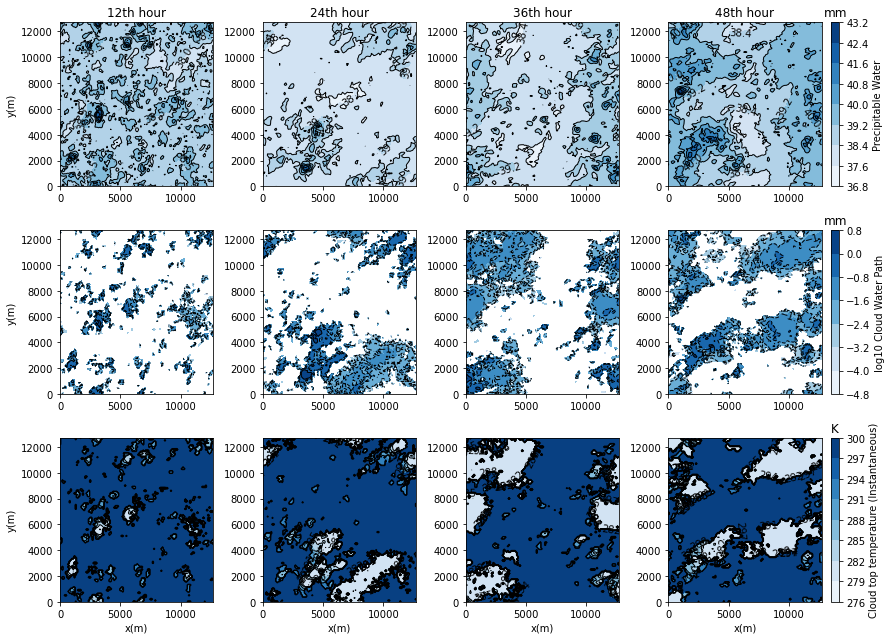

In [134]:
locdir ='Figs'
var_list = ['PW','logCWP', 'TB']
test.spatial_map(var_list = var_list, zlev=0, ColIntFlag=True, simThr=[12,24,36,48], figsize=(12.5,9), 
                 colormap=cm.Blues,svfig=True, svdir=locdir, figname_suff='PW_CWP_TB')

saving figure as RICO_RRTM_3day_spatial_evolution_of_SurfaceWind_850mbWind.jpg
to /data/xchen/SAM_LES_Orion/RICO_RRTM_3day/Figs


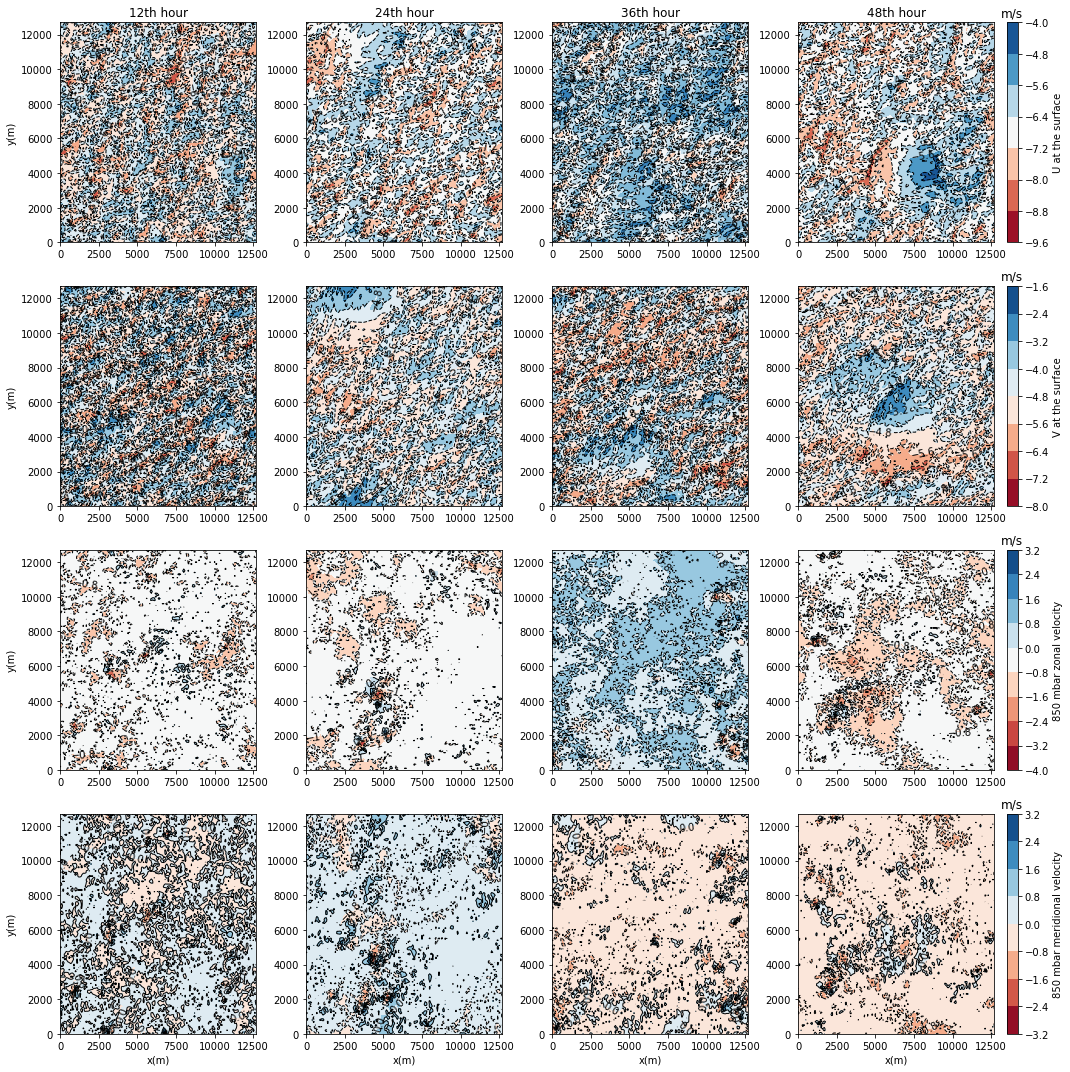

In [133]:
# try fixing the range of the colorbar to be equal in positive and negative range.
var_list = ['USFC','VSFC', 'U850','V850']
test.spatial_map(var_list = var_list, zlev=0, ColIntFlag=True, simThr=[12,24,36,48], figsize=(15,15), 
                 colormap=cm.RdBu,svfig=True, svdir=locdir, figname_suff='SurfaceWind_850mbWind')

In [ ]:
var_list = test.var

z = test.nc['z']
time = test.nc['time'] * 24.  # hours
TT, ZZ = np.meshgrid(time, z)
nrow = 2
np.shape(TT)
np.shape(nc.CLD)

In [ ]:
var_list = 'U'
fig, axes = plt.subplots(nrow,1, figsize=(14,10))
for varname, ax in zip(var_list, axes.flatten()):
    print(varname, ax)
    hm = ax.pcolormesh(TT, ZZ, nc[varname].T, shading = 'auto', cmap='viridis')
    ax.plot(time, nc['ZINV']*1000, '--w',linewidth=1.2)
    ax.set_xlabel('Simulation Time (hrs)')
    ax.set_ylabel('Height (m)')
    ax.set_title(nc[varname].long_name)

    # set up the colorbar:
    hb = plt.colorbar(hm, ax=ax)
    hb.ax.set_title(nc[varname].units)
    fig.tight_layout()

In [ ]:
print(test.path)

In [ ]:
plt.plot(nc['UOBS'][0,:],nc.z, )

In [31]:
nc.x.name


'x'

In [ ]:
nc_sel = nc.sel(z=100, method='nearest')

LWP
1 AxesSubplot(0.125,0.536818;0.352273x0.343182)
60 AxesSubplot(0.547727,0.536818;0.352273x0.343182)


TypeError: colorbar() missing 1 required positional argument: 'mappable'

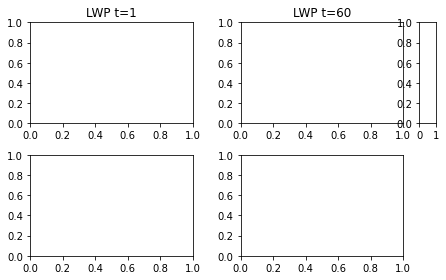

In [63]:
import matplotlib.pyplot as plt

ts = [1,60]
varlist = ['LWP','TWP']
fig, ax = plt.subplots(2,2)
for iv, var in enumerate(varlist):
    print(var)
    for (a,c) in zip(ts, ax[iv].flatten()):
        print(a,c)
        c.set_title(var + ' t={0:d}'.format(a))
        

        

    fig.tight_layout()
    pos1 = c.get_position()
    pos2 = [pos1.x0 + 1.1*pos1.width, pos1.y0, pos1.width/10, pos1.height]
    cbar = fig.add_axes(pos2)
    hb = fig.colorbar(ax=cbar)
    

In [108]:
c.set_xt

In [ ]:
import numpy as np
np.shape(ax[1])

In [129]:
nc

<xarray.Dataset>
Dimensions:  (time: 427, x: 128, y: 128)
Coordinates:
  * x        (x) float32 0.0 100.0 200.0 300.0 ... 1.25e+04 1.26e+04 1.27e+04
  * y        (y) float32 0.0 100.0 200.0 300.0 ... 1.25e+04 1.26e+04 1.27e+04
  * time     (time) float32 0.04167 0.04861 0.05556 0.0625 ... 2.986 2.993 3.0
Data variables: (12/21)
    Prec     (time, y, x) float32 ...
    SHF      (time, y, x) float32 ...
    LHF      (time, y, x) float32 ...
    CWP      (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    IWP      (time, y, x) float32 ...
    CLD      (time, y, x) float32 ...
    ...       ...
    V850     (time, y, x) float32 ...
    ZC       (time, y, x) float32 ...
    TB       (time, y, x) float32 ...
    ZE       (time, y, x) float32 ...
    TWP      (time, y, x) float32 37.78 37.84 37.88 37.9 ... 40.11 40.19 40.13
    logCWP   (time, y, x) float32 -inf -inf -inf -inf ... -inf -inf -inf -inf